# **IT2011 - End-to-End Preprocessing Pipeline**

This notebook combines the work of all group members into a single, integrated pipeline. It takes the raw student depression dataset and processes it through cleaning, encoding, outlier removal, scaling, feature selection, and dimensionality reduction.

**Group Members & Roles:**
- **Handling Missing Values:** Dinuka
- **Encoding:** Kavisha
- **Outlier Removal:** Parami
- **Scaling:** Sakitha
- **Feature Selection:** Hiruna
- **PCA (Dimensionality Reduction):** Janith

# **0. Initial Setup**

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
!pip install category_encoders
import category_encoders as ce

# **1. Load Data & Handle Missing Values (Contribution: Dinuka)**

In [76]:
#Load the dataset
df = pd.read_csv('Student Depression Dataset.csv')

In [77]:
#Separate into Features (X) and Target (y)
y = df['Depression']
X = df.drop(columns=['Depression'], errors='ignore')

In [78]:
#Find the missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Financial Stress    3
dtype: int64


/tmp/ipython-input-1274110308.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_values.index, y=missing_values.values, palette="viridis")


 'missing_values_before.png' has been saved.


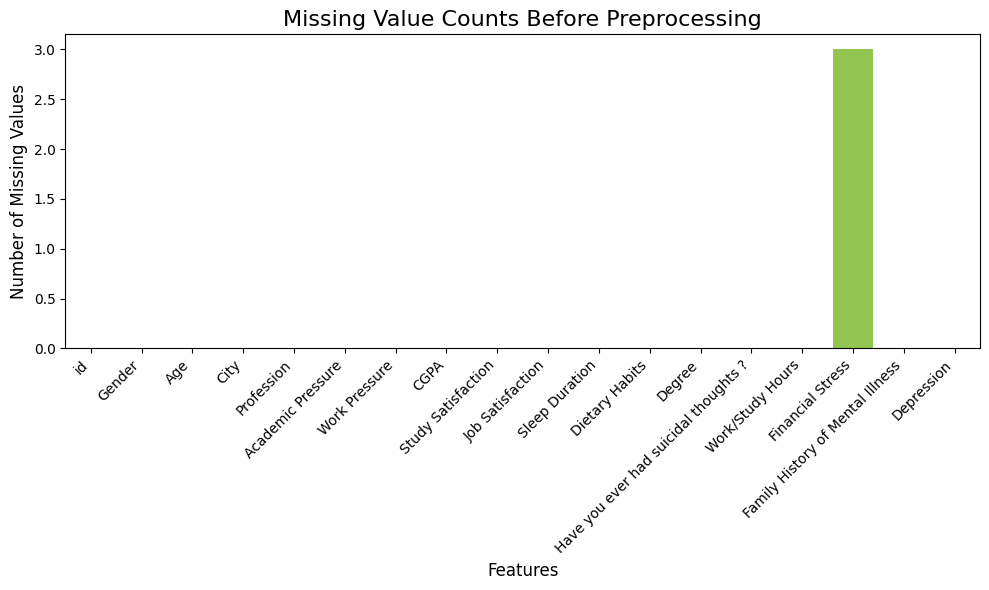

In [79]:
#Create the bar chart to show the missing values
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title('Missing Value Counts Before Preprocessing', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Number of Missing Values', fontsize=12)
plt.tight_layout() # Adjust layout to make room for labels
plt.savefig('missing_values_before.png')
print(" 'missing_values_before.png' has been saved.")
plt.show()

In [80]:
#Fill missing numerical values with the MEDIAN
numerical_cols = X.select_dtypes(include=np.number).columns
for col in numerical_cols:
    if X[col].isnull().any():
        median_val = X[col].median()
        X[col] = X[col].fillna(median_val)
        print(f"Filled missing values in '{col}' with median: {median_val}")

Filled missing values in 'Financial Stress' with median: 3.0


In [81]:
#Verify that all missing values have been handled
print(f"\nTotal missing values remaining in X: {X.isnull().sum().sum()}")


Total missing values remaining in X: 0


In [82]:
df = pd.concat([X, y], axis=1)

/tmp/ipython-input-3924550181.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_after.index, y=missing_after.values, palette="plasma")


 'missing_values_after.png' has been saved.


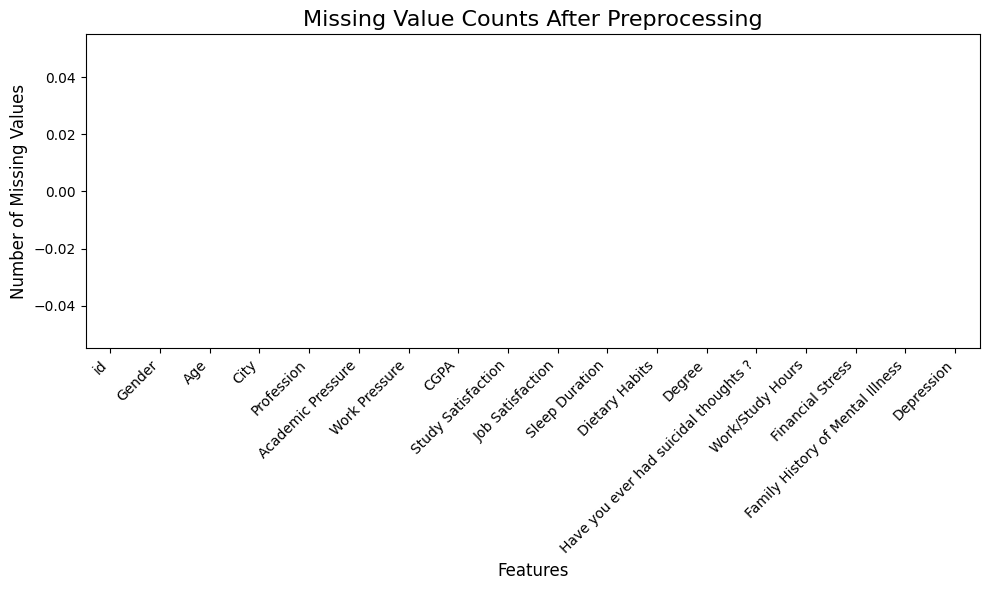

In [83]:
#Create a plot to visually confirm that no missing values are left
plt.figure(figsize=(10, 6))
missing_after = df.isnull().sum()
sns.barplot(x=missing_after.index, y=missing_after.values, palette="plasma")
plt.xticks(rotation=45, ha='right')
plt.title('Missing Value Counts After Preprocessing', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Number of Missing Values', fontsize=12)
plt.tight_layout()
plt.savefig('missing_values_after.png')
print(" 'missing_values_after.png' has been saved.")
plt.show()


# **2. Categorical Feature Encoding (Contribution: Kavisha)**


In [84]:
# Drop the id colum
if 'id' in df.columns:
    df = df.drop('id', axis=1)

/tmp/ipython-input-2160416623.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_depression_mean.index, y=city_depression_mean.values, palette="viridis")


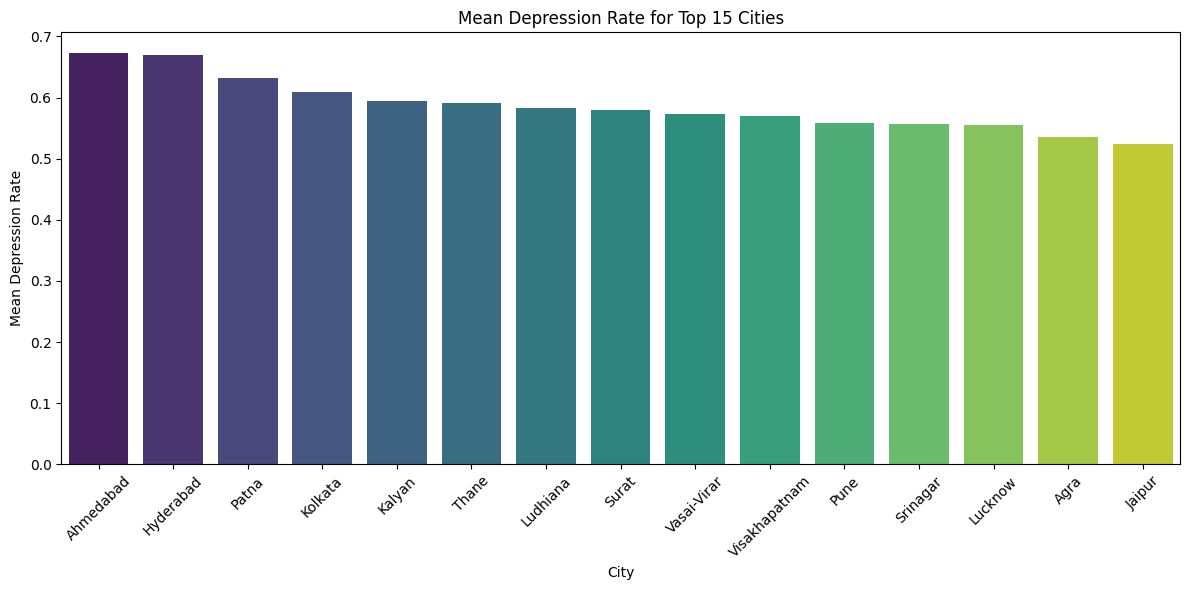

In [85]:
#EDA: Analyzing Categorical Feature Impact on Depression
top_cities = df['City'].value_counts().nlargest(15).index
city_depression_mean = df[df['City'].isin(top_cities)].groupby('City')['Depression'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=city_depression_mean.index, y=city_depression_mean.values, palette="viridis")
plt.title('Mean Depression Rate for Top 15 Cities')
plt.xlabel('City')
plt.ylabel('Mean Depression Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1142927342.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sleep_depression_mean.index, y=sleep_depression_mean.values, palette="plasma")


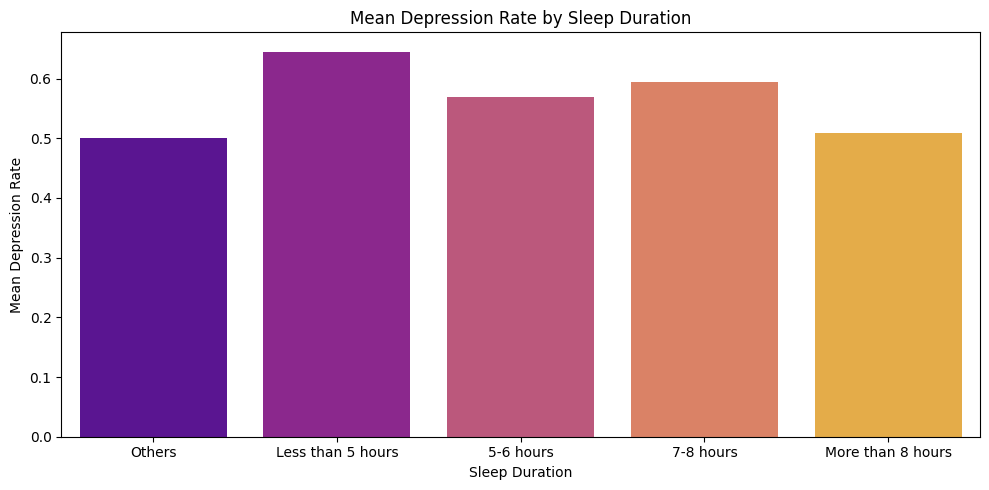

In [86]:
sleep_order = ['Others', 'Less than 5 hours', '5-6 hours', '7-8 hours', 'More than 8 hours']
sleep_depression_mean = df.groupby('Sleep Duration')['Depression'].mean().reindex(sleep_order)

plt.figure(figsize=(10, 5))
sns.barplot(x=sleep_depression_mean.index, y=sleep_depression_mean.values, palette="plasma")
plt.title('Mean Depression Rate by Sleep Duration')
plt.xlabel('Sleep Duration')
plt.ylabel('Mean Depression Rate')
plt.tight_layout()
plt.show()

Starting Data Encodin

In [87]:
df_encoded = df.copy()

In [88]:
#Encoding binary features
# Gender: Male=1, Female=0
df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})

# Suicidal thoughts: Yes=1, No=0
df["Have you ever had suicidal thoughts ?"] = df["Have you ever had suicidal thoughts ?"].map({"Yes": 1, "No": 0})

# Family history: Yes=1, No=0
df["Family History of Mental Illness"] = df["Family History of Mental Illness"].map({"Yes": 1, "No": 0})

In [89]:
#Encoding Ordinal features
# Sleep Duration (example: "5-6 hours"=1, else=0 → adjust if needed)
df["Sleep Duration"] = df["Sleep Duration"].map({
    "Less than 5 hours": 0,
    "5-6 hours": 1,
    "7-8 hours": 2,
    "More than 8 hours": 3
})

# Dietary Habits: Healthy=1, else=0
df["Dietary Habits"] = df["Dietary Habits"].map({
    "Healthy": 0,
    "Moderate": 1,
    "Unhealthy": 3
})

In [90]:
#Split Data BEFORE Target Encoding
X = df_encoded.drop('Depression', axis=1)
y = df_encoded['Depression']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 22320, Testing samples: 5581


In [91]:
#Target Encode High-Cardinality Features
high_card_cols = ['City', 'Profession', 'Degree']

target_encoder = ce.TargetEncoder(cols=high_card_cols)
target_encoder.fit(X_train, y_train)

X_train = target_encoder.transform(X_train)
X_test = target_encoder.transform(X_test)

In [92]:
#verifying encoding
display(X_train.head())

,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
13048,Male,28.0,0.530909,0.586499,2.0,0.0,8.29,5.0,0.0,5-6 hours,Moderate,0.548458,No,4.0,1.0,Yes
24535,Female,33.0,0.620647,0.586499,4.0,0.0,9.05,4.0,0.0,Less than 5 hours,Healthy,0.538333,No,12.0,4.0,Yes
15303,Female,33.0,0.519802,0.586499,4.0,0.0,8.08,4.0,0.0,Less than 5 hours,Healthy,0.523702,Yes,12.0,3.0,No
22444,Female,29.0,0.546351,0.586499,2.0,0.0,5.76,4.0,0.0,5-6 hours,Moderate,0.501515,No,10.0,2.0,Yes
18744,Female,20.0,0.593861,0.586499,5.0,0.0,5.77,5.0,0.0,7-8 hours,Moderate,0.711325,Yes,11.0,5.0,No


# **3. Outlier Removal from Training Data (Contribution: Parami)**


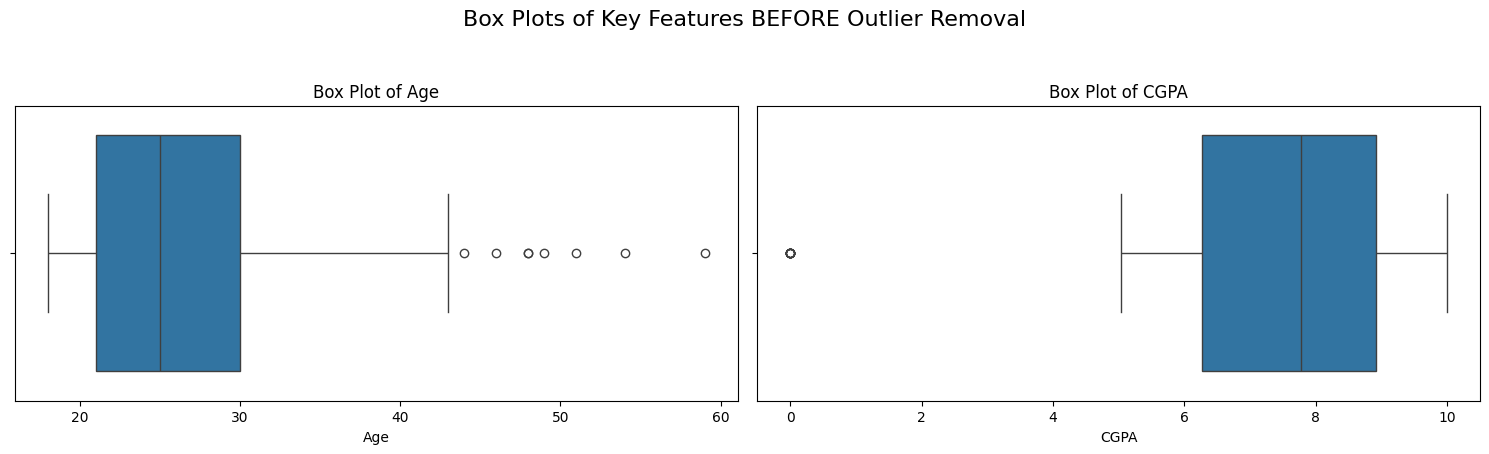

In [93]:
#EDA - Visualize Outliers with Box Plots (Before Removal)

# Select key numerical features to inspect for outliers
# We only inspect the TRAINING data
features_to_check = ['Age', 'CGPA']

plt.figure(figsize=(15, 8))
plt.suptitle("Box Plots of Key Features BEFORE Outlier Removal", fontsize=16)

for i, feature in enumerate(features_to_check):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x=X_train[feature])
    plt.title(f'Box Plot of {feature}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [94]:
#Identify and Remove Outliers from the Training Set
print("\n--- Identifying and removing outliers from the training data only ---")

# Select only the numerical columns for IQR calculation
numerical_cols = X_train.select_dtypes(include=np.number).columns

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = X_train[numerical_cols].quantile(0.25)
Q3 = X_train[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify rows that contain outliers in any of the numerical columns
outlier_mask = ((X_train[numerical_cols] < lower_bound) | (X_train[numerical_cols] > upper_bound)).any(axis=1)

# Get the indices of the outlier rows
outlier_indices = X_train[outlier_mask].index

print(f"Original number of samples in training data: {len(X_train)}")
print(f"Number of outliers detected: {len(outlier_indices)}")

# Remove the outliers from both X_train and y_train
X_train= X_train.drop(outlier_indices)
y_train= y_train.drop(outlier_indices)

print(f"New number of samples in training data: {len(X_train)}")
print(f"Shape of X_test (unchanged): {X_test.shape}")


--- Identifying and removing outliers from the training data only ---
Original number of samples in training data: 22320
Number of outliers detected: 4909
New number of samples in training data: 17411
Shape of X_test (unchanged): (5581, 16)


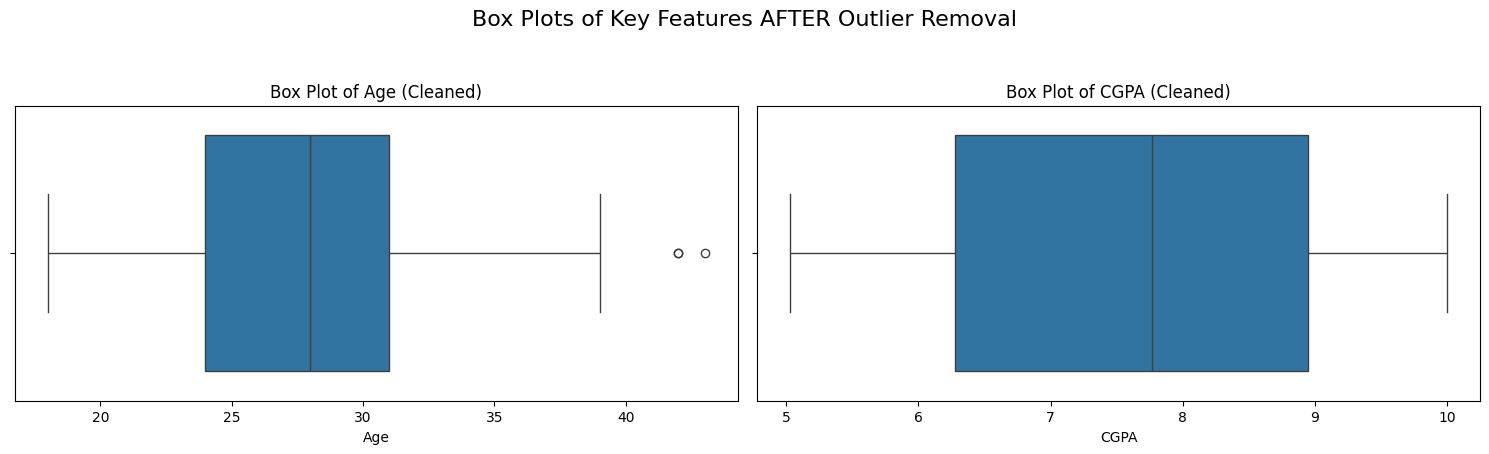

In [95]:
# EDA - Visualize Data with Box Plots (After Removal)
plt.figure(figsize=(15, 8))
plt.suptitle("Box Plots of Key Features AFTER Outlier Removal", fontsize=16)

for i, feature in enumerate(features_to_check):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x=X_train[feature])
    plt.title(f'Box Plot of {feature} (Cleaned)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

This is because the box plot's boundaries are recalculated based on the new, tighter distribution of the cleaned data. These remaining points are not extreme and removing them further could risk deleting valuable data. Therefore, we made a conscious decision to perform only one pass of outlier removal to eliminate the most influential outliers while preserving the integrity of the dataset. The resulting data is now more robust for model training

# **4. Feature Scaling (Contribution: Sakitha)**

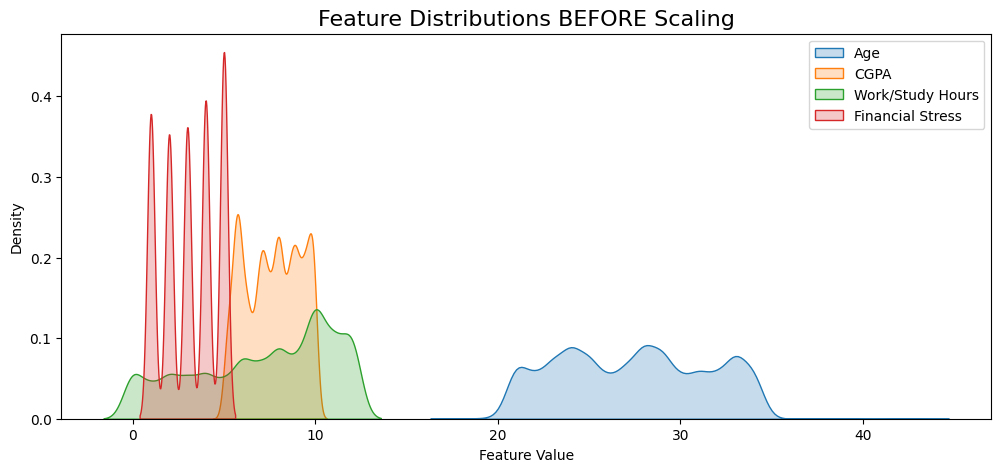

In [96]:
#EDA - Visualize Feature Distributions (Before Scaling)

# Select the same key numerical features for consistency
features_to_plot = ['Age', 'CGPA', 'Work/Study Hours', 'Financial Stress']

plt.figure(figsize=(12, 5))
plt.title("Feature Distributions BEFORE Scaling", fontsize=16)
for feature in features_to_plot:
    sns.kdeplot(X_train[feature], label=feature, fill=True)
plt.xlabel("Feature Value")
plt.ylabel("Density")
plt.legend()
plt.show()

In [97]:
#Apply StandardScaler to Numerical Features
print("\n--- Applying StandardScaler ---")

# Initialize the scaler
scaler = StandardScaler()

# Identify all numerical columns to be scaled
numerical_cols = X_train.select_dtypes(include=np.number).columns

# Fit the scaler on the TRAINING data and transform it
# This learns the mean and std dev from the training set only
X_train_scaled = scaler.fit_transform(X_train[numerical_cols])

# Use the SAME fitted scaler to transform the TEST data
# We do NOT fit again on the test data to avoid data leakage
X_test_scaled = scaler.transform(X_test[numerical_cols])

# Convert the scaled arrays back to DataFrames to keep column names
X_train = pd.DataFrame(X_train_scaled, columns=numerical_cols)
X_test = pd.DataFrame(X_test_scaled, columns=numerical_cols)

print("Scaling complete. Displaying the first 5 rows of the scaled training data:")
display(X_train.head())


--- Applying StandardScaler ---
Scaling complete. Displaying the first 5 rows of the scaled training data:


,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Degree,Work/Study Hours,Financial Stress
0,0.151151,-1.402300,-2.220446e-16,-0.779413,0.0,0.423719,1.544157,0.0,-0.125874,-0.832188,-1.453043
1,1.396506,0.894345,-2.220446e-16,0.653873,0.0,0.938558,0.806583,0.0,-0.480612,1.309051,0.622057
2,1.396506,-1.686563,-2.220446e-16,0.653873,0.0,0.281462,0.806583,0.0,-0.993241,1.309051,-0.069643
3,0.400222,-1.007095,-2.220446e-16,-0.779413,0.0,-1.290150,0.806583,0.0,-1.770590,0.773741,-0.761343
4,-0.097920,0.240675,-2.220446e-16,0.653873,0.0,1.067267,-0.668566,0.0,-0.125874,-0.832188,-0.761343


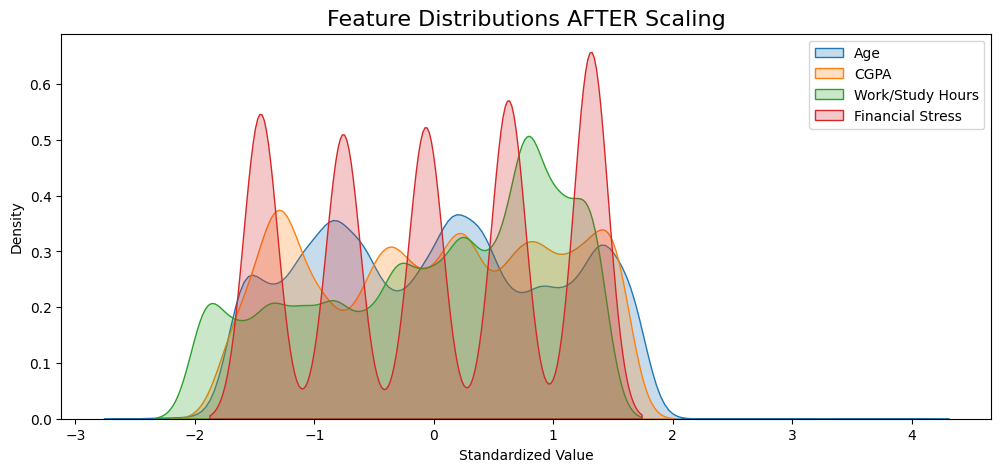

In [98]:
#EDA - Visualize Feature Distributions (After Scaling)
plt.figure(figsize=(12, 5))
plt.title("Feature Distributions AFTER Scaling", fontsize=16)
for feature in features_to_plot:
    sns.kdeplot(X_train[feature], label=feature, fill=True)
plt.xlabel("Standardized Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# **5. Feature Selection (Contribution: Hiruna)**


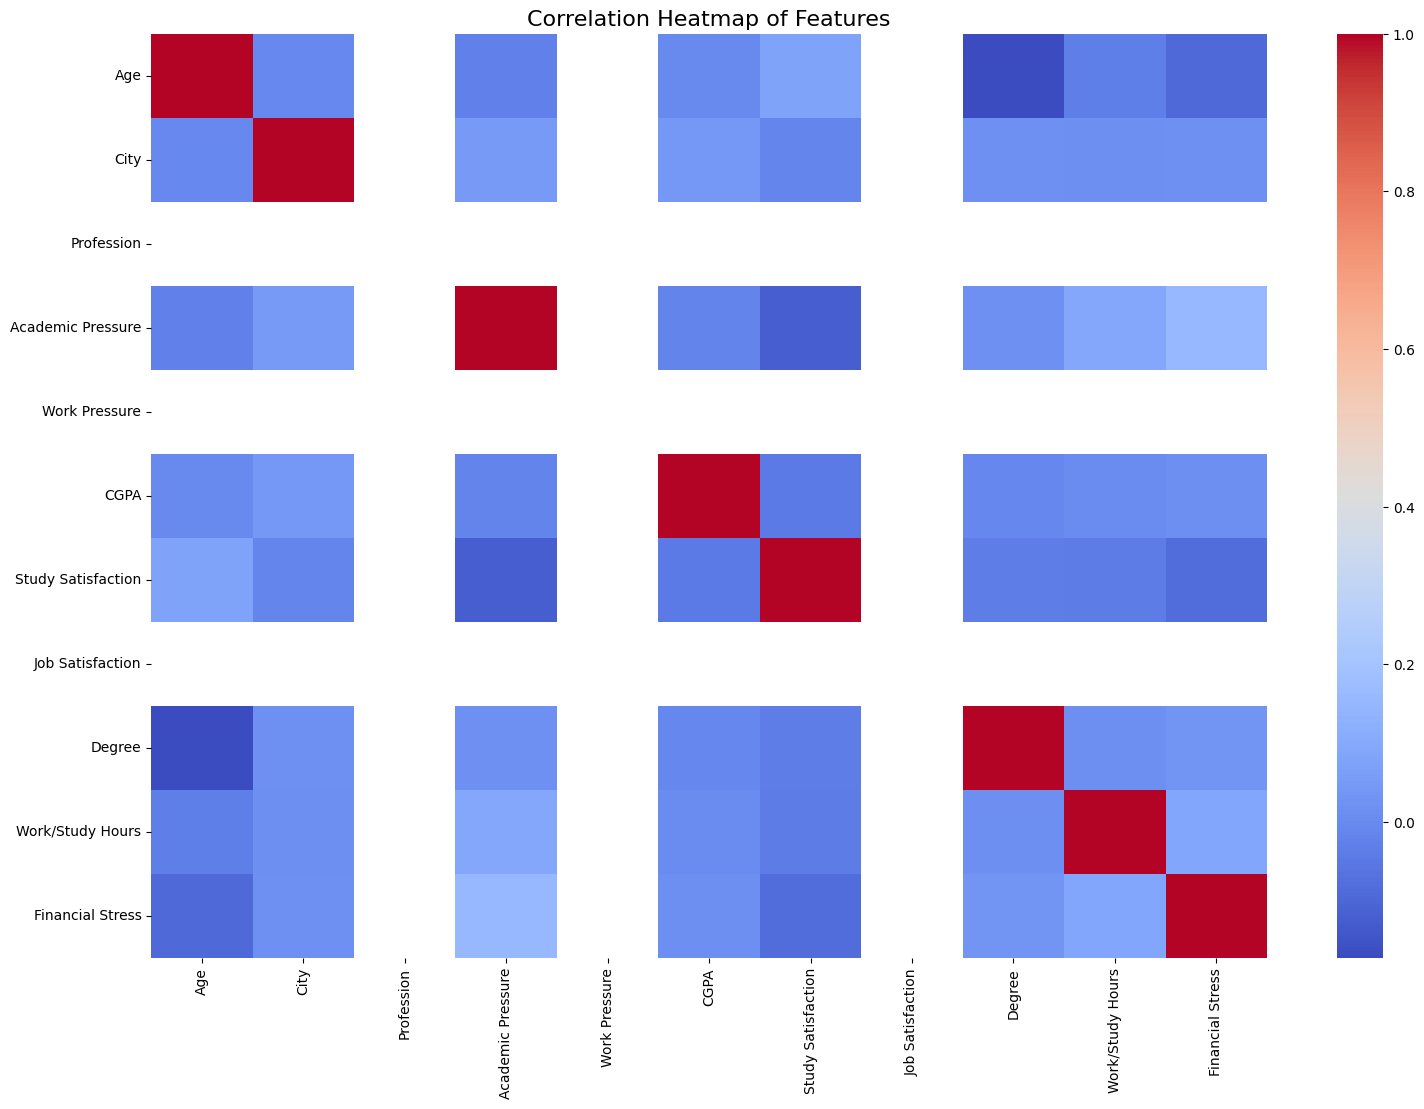


No features with correlation > 0.8 found to drop.
Shape of training data after correlation check: (17411, 11)


In [99]:
#Correlation Analysis

plt.figure(figsize=(18, 12))
sns.heatmap(X_train.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Features', fontsize=16)
plt.show()

# --- Find and remove highly correlated features ---
# Create correlation matrix
corr_matrix = X_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.8 (a common threshold)
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

if not to_drop:
    print("\nNo features with correlation > 0.8 found to drop.")
else:
    print(f"\nDropping features with correlation > 0.8: {to_drop}")
    X_train = X_train.drop(to_drop, axis=1)
    X_test = X_test.drop(to_drop, axis=1)

print("Shape of training data after correlation check:", X_train.shape)

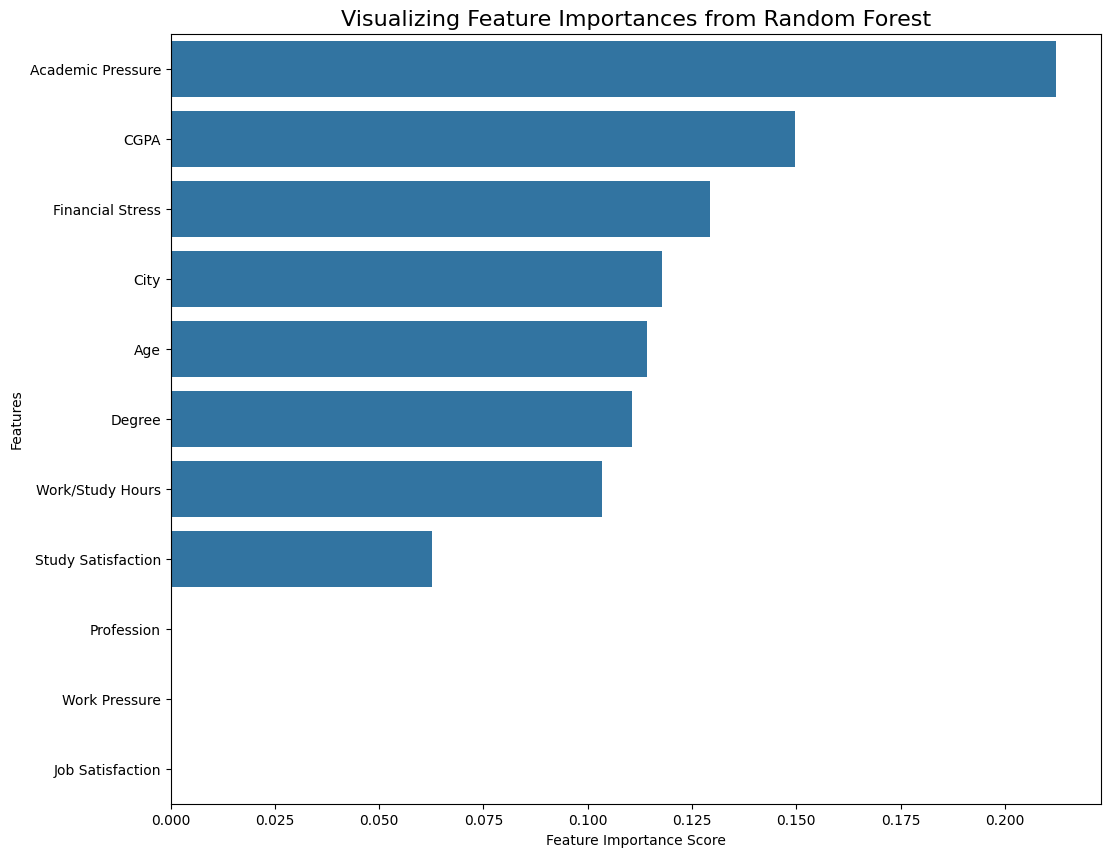

Feature Importances:
Academic Pressure     0.212342
CGPA                  0.149670
Financial Stress      0.129307
City                  0.117898
Age                   0.114098
Degree                0.110622
Work/Study Hours      0.103495
Study Satisfaction    0.062567
Profession            0.000000
Work Pressure         0.000000
Job Satisfaction      0.000000
dtype: float64


In [100]:
#Random Forest Feature Importance

# Train a RandomForestClassifier to get feature importance scores
# random_state ensures reproducibility
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_rf.fit(X_train, y_train)

# Create a pandas Series for easy plotting
importances = pd.Series(model_rf.feature_importances_, index=X_train.columns)

# Sort the feature importances in descending order
sorted_importances = importances.sort_values(ascending=False)

# --- EDA: Visualize Feature Importances ---
plt.figure(figsize=(12, 10))
sns.barplot(x=sorted_importances, y=sorted_importances.index)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Visualizing Feature Importances from Random Forest", fontsize=16)
plt.show()

print("Feature Importances:")
print(sorted_importances)

In [101]:
#Selecting the Final Set of Features

# We will select the top 12 most important features as an example
# This number can be tuned later as a hyperparameter

N_FEATURES = 12
final_features = sorted_importances.nlargest(N_FEATURES).index.tolist()

print(f"\nSelected Top {N_FEATURES} Features: \n{final_features}")

# Create the final datasets with only the selected features
X_train_final = X_train[final_features]
X_test_final = X_test[final_features]

print(f"\nFinal shape of training data: {X_train_final.shape}")


Selected Top 12 Features: 
['Academic Pressure', 'CGPA', 'Financial Stress', 'City', 'Age', 'Degree', 'Work/Study Hours', 'Study Satisfaction', 'Profession', 'Work Pressure', 'Job Satisfaction']

Final shape of training data: (17411, 11)


# **6. PCA for Visualization (Contribution: Janith)**

In [102]:
#Apply PCA

# Initialize PCA. We set n_components=None to first see how much variance
# each of the possible components explains.
pca = PCA(n_components=None, random_state=42)

# Fit the PCA model on the TRAINING data only
pca.fit(X_train)

# Transform both the training and testing data using the fitted model
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("PCA transformation complete.")

PCA transformation complete.


PCA Explained Variance Summary:


,PC,Explained Variance (%),Cumulative Variance (%)
0,PC1,17.26,17.26
1,PC2,13.96,31.22
2,PC3,13.00,44.22
3,PC4,12.26,56.48
4,PC5,11.89,68.36
5,PC6,11.24,79.60
6,PC7,10.47,90.07
7,PC8,9.93,100.00
8,PC9,0.00,100.00
9,PC10,0.00,100.00


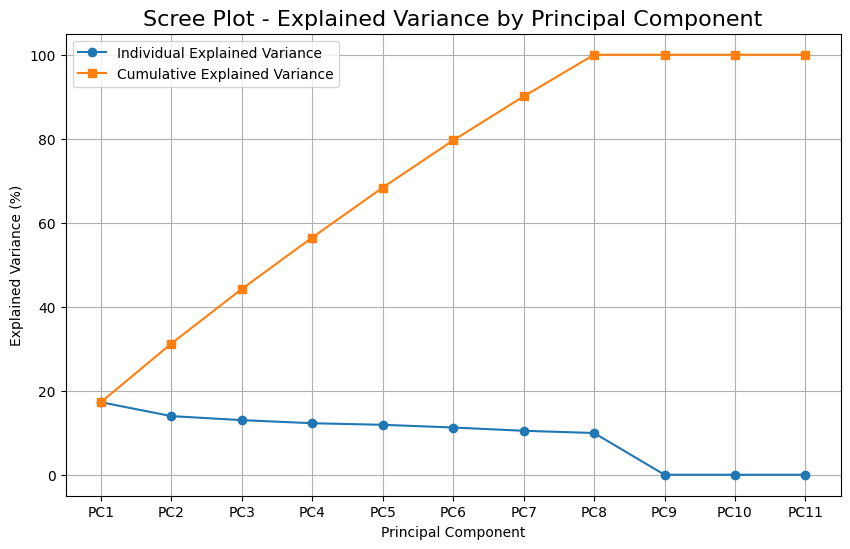

In [103]:
#EDA - Visualize Explained Variance with a Scree Plot
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Create a summary DataFrame
pca_summary = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(explained_variance_ratio))],
    "Explained Variance (%)": explained_variance_ratio * 100,
    "Cumulative Variance (%)": cumulative_variance_ratio * 100
})

print("PCA Explained Variance Summary:")
display(pca_summary.round(2))

# Plot the Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(pca_summary["PC"], pca_summary["Explained Variance (%)"], marker='o', label="Individual Explained Variance")
plt.plot(pca_summary["PC"], pca_summary["Cumulative Variance (%)"], marker='s', label="Cumulative Explained Variance")
plt.title("Scree Plot - Explained Variance by Principal Component", fontsize=16)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance (%)")
plt.legend()
plt.grid(True)
plt.show()

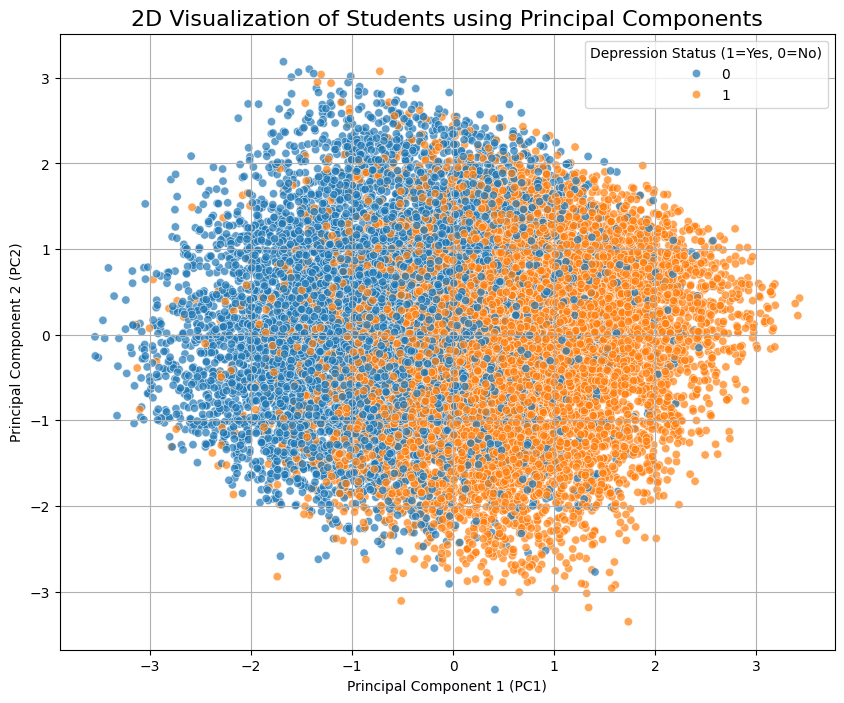

In [104]:
#EDA - Visualize Data in 2D PCA Space

# Create a DataFrame for plotting with seaborn
df_train_pca = pd.DataFrame(data=X_train_pca[:, :2], columns=['PC1', 'PC2'])
df_train_pca['Depression'] = y_train.values # Add the target variable for coloring

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Depression', data=df_train_pca, alpha=0.7)
plt.title("2D Visualization of Students using Principal Components", fontsize=16)
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.legend(title='Depression Status (1=Yes, 0=No)')
plt.grid(True)
plt.show()

In [105]:
print("\n✅ End-to-end preprocessing pipeline complete.")


✅ End-to-end preprocessing pipeline complete.


# **Save the Final Data for the Next Handoff (Model Training)**

In [106]:
# Save the final, feature-selected datasets
X_train_final.to_csv('X_train_final.csv', index=False)
X_test_final.to_csv('X_test_final.csv', index=False)

# Pass along the corresponding labels (these haven't changed)
y_train.to_csv('y_train_final.csv', index=False)
y_test.to_csv('y_test_final.csv', index=False)

print("\n Handoff successful! Final feature-selected datasets have been saved.")


✅ Handoff successful! Final feature-selected datasets have been saved.
